##Mile Stone 1:Data Collection

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:48<00:00, 22.8MB/s]
100% 1.03G/1.03G [00:48<00:00, 22.9MB/s]


In [ ]:
!unzip asl-alphabet.zip -d asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alp

## MILESTONE 2: DATA PREPARATION

In [ ]:
!pip install imutils

In [ ]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 15
    num_classes = 29
    img_channels = 3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
# Labels
TRAIN_PATH = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

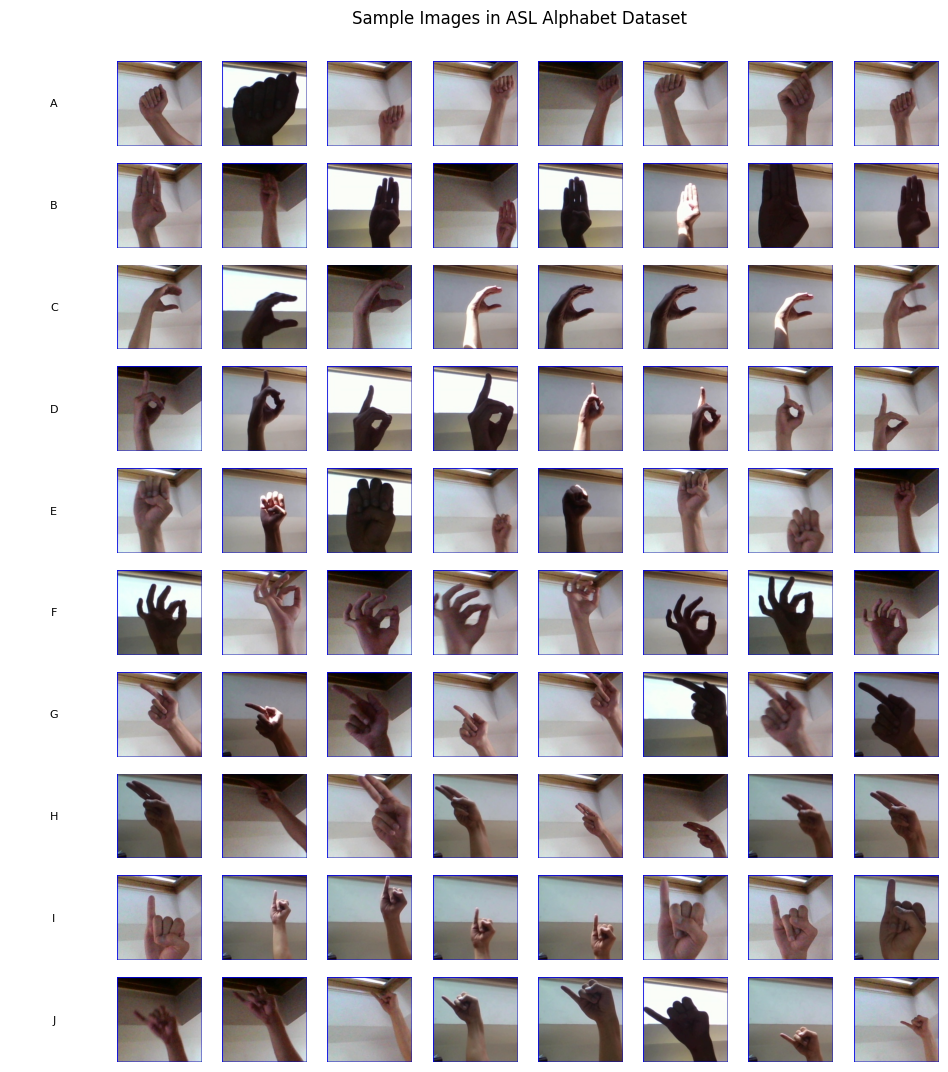

In [ ]:
sample_images(labels[:10])

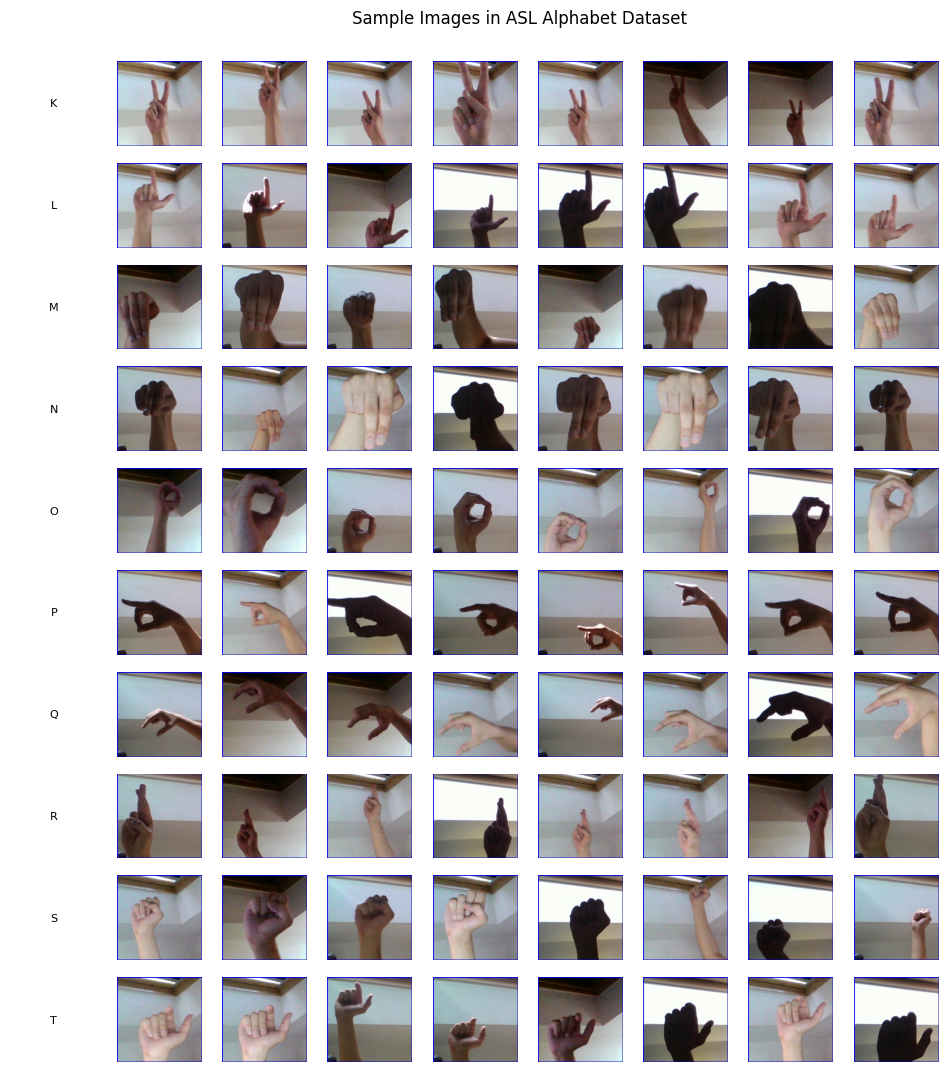

In [ ]:
sample_images(labels[10:20])

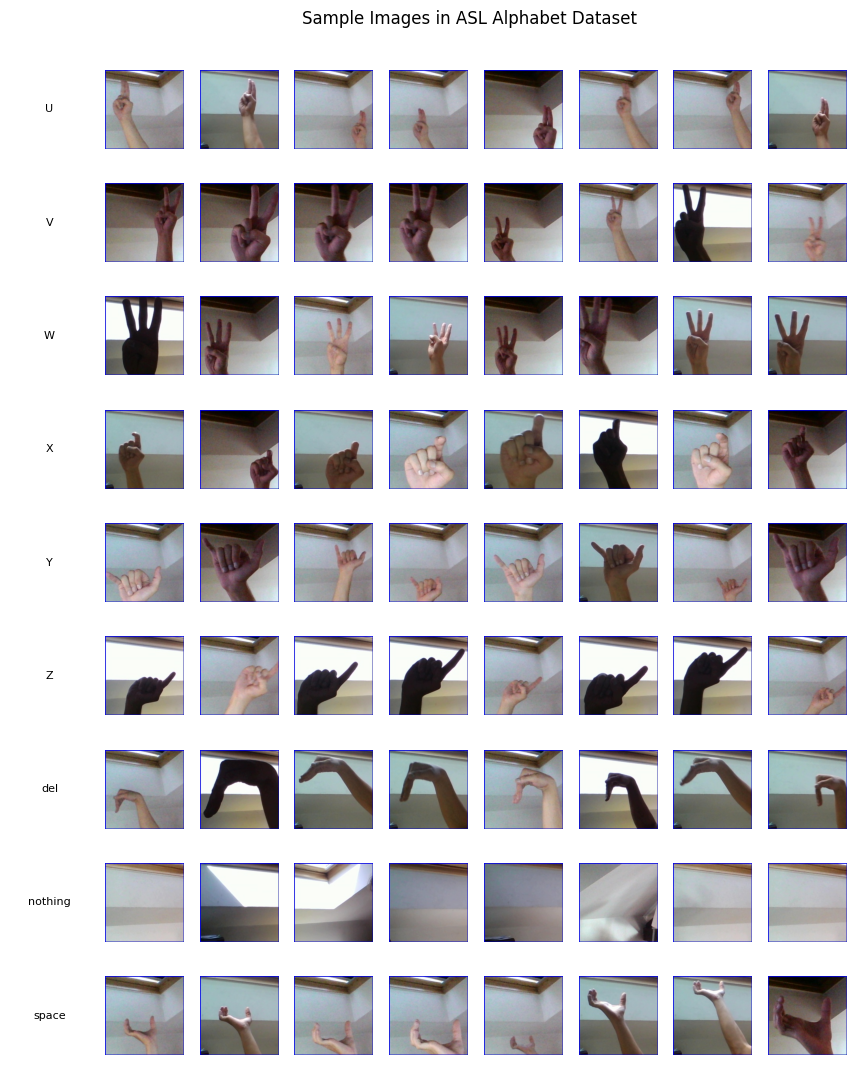

In [ ]:
sample_images(labels[20:])

## MILESTONE 3 : DATA PREPROCESSING

In [ ]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      /content/asl-alphabet/asl_alphabet_train/asl_a...      A
1      /content/asl-alphabet/asl_alphabet_train/asl_a...      A
2      /content/asl-alphabet/asl_alphabet_train/asl_a...      A
3      /content/asl-alphabet/asl_alphabet_train/asl_a...      A
4      /content/asl-alphabet/asl_alphabet_train/asl_a...      A
...                                                  ...    ...
86995  /content/asl-alphabet/asl_alphabet_train/asl_a...  space
86996  /content/asl-alphabet/asl_alphabet_train/asl_a...  space
86997  /content/asl-alphabet/asl_alphabet_train/asl_a...  space
86998  /content/asl-alphabet/asl_alphabet_train/asl_a...  space
86999  /content/asl-alphabet/asl_alphabet_train/asl_a...  space

[87000 rows x 2 columns]

In [ ]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path    label
51901  /content/asl-alphabet/asl_alphabet_train/asl_a...        R
51887  /content/asl-alphabet/asl_alphabet_train/asl_a...        R
5050   /content/asl-alphabet/asl_alphabet_train/asl_a...        B
29446  /content/asl-alphabet/asl_alphabet_train/asl_a...        J
58405  /content/asl-alphabet/asl_alphabet_train/asl_a...        T
...                                                  ...      ...
47111  /content/asl-alphabet/asl_alphabet_train/asl_a...        P
83611  /content/asl-alphabet/asl_alphabet_train/asl_a...  nothing
67329  /content/asl-alphabet/asl_alphabet_train/asl_a...        W
85296  /content/asl-alphabet/asl_alphabet_train/asl_a...    space
60158  /content/asl-alphabet/asl_alphabet_train/asl_a...        U

[58103 rows x 2 columns]

image_path label
24961  /content/asl-alphabet/asl_alphabet_train/asl_a...     I
71053  /content/asl-alphabet/asl_alphabet_train/asl_a...     X
73637  /content/asl-alphabet/asl_alphabet_train/asl_a...     Y
72875  /content/asl-alphabet/asl_alphabet_train/asl_a...     Y
40669  /content/asl-alphabet/asl_alphabet_train/asl_a...     N
...                                                  ...   ...
16474  /content/asl-alphabet/asl_alphabet_train/asl_a...     F
62741  /content/asl-alphabet/asl_alphabet_train/asl_a...     U
32281  /content/asl-alphabet/asl_alphabet_train/asl_a...     K
20451  /content/asl-alphabet/asl_alphabet_train/asl_a...     G
2962   /content/asl-alphabet/asl_alphabet_train/asl_a...     A

[15847 rows x 2 columns]

image_path  label
73327  /content/asl-alphabet/asl_alphabet_train/asl_a...      Y
85482  /content/asl-alphabet/asl_alphabet_train/asl_a...  space
65607  /content/asl-alphabet/asl_alphabet_train/asl_a...      V
53903  /content/asl-alphabet/asl_alphabet_train/asl_a...      R
64425  /content/asl-alphabet/asl_alphabet_train/asl_a...      V
...                                                  ...    ...
40578  /content/asl-alphabet/asl_alphabet_train/asl_a...      N
28949  /content/asl-alphabet/asl_alphabet_train/asl_a...      J
42094  /content/asl-alphabet/asl_alphabet_train/asl_a...      O
5425   /content/asl-alphabet/asl_alphabet_train/asl_a...      B
49381  /content/asl-alphabet/asl_alphabet_train/asl_a...      Q

[13050 rows x 2 columns]

## Data Augmentation:

In [ ]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


## MILESTONE 4 : MODEL BUILDING

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

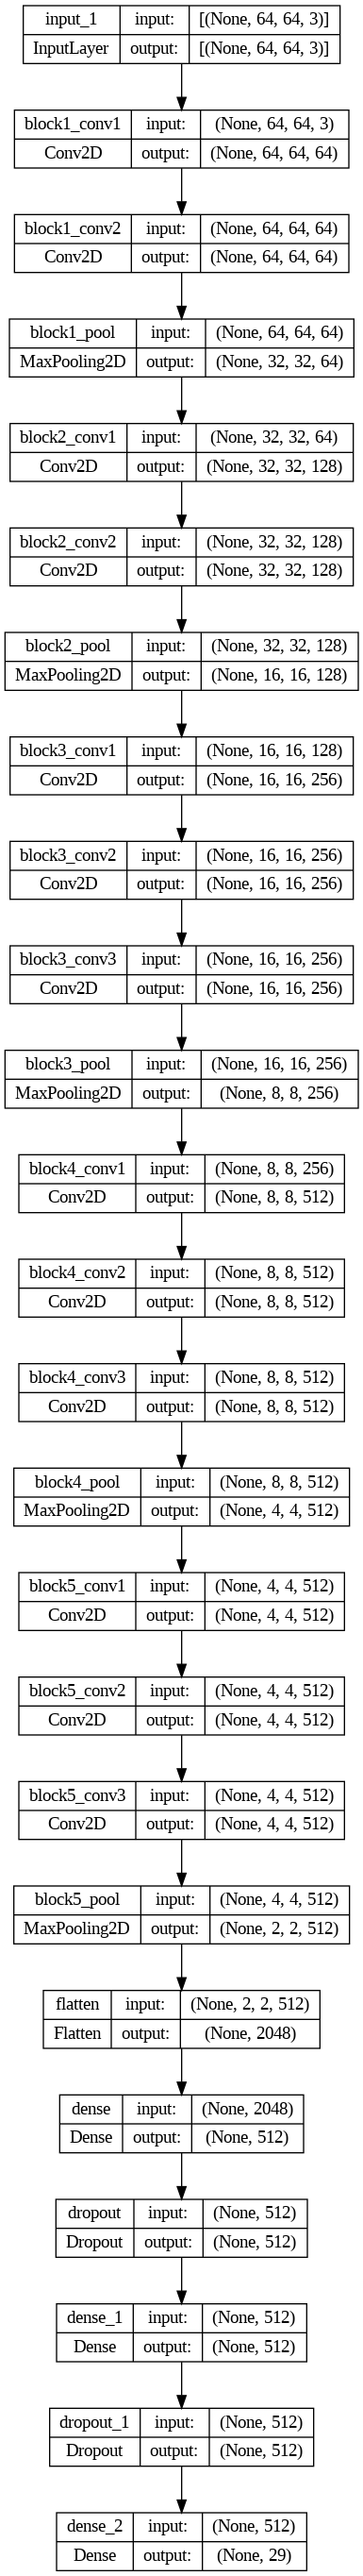

In [ ]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [ ]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/15
907/907 [==============================] - 90s 87ms/step - loss: 1.1007 - accuracy: 0.6551 - val_loss: 0.2402 - val_accuracy: 0.9323
Epoch 2/15
907/907 [==============================] - 74s 81ms/step - loss: 0.3863 - accuracy: 0.8693 - val_loss: 0.1143 - val_accuracy: 0.9662
Epoch 3/15
907/907 [==============================] - 66s 73ms/step - loss: 0.2834 - accuracy: 0.9035 - val_loss: 0.0963 - val_accuracy: 0.9721
Epoch 4/15
907/907 [==============================] - 67s 74ms/step - loss: 0.2414 - accuracy: 0.9173 - val_loss: 0.0740 - val_accuracy: 0.9786
Epoch 5/15
907/907 [==============================] - 74s 82ms/step - loss: 0.2183 - accuracy: 0.9258 - val_loss: 0.0502 - val_accuracy: 0.9881
Epoch 6/15
907/907 [==============================] - 67s 73ms/step - loss: 0.1998 - accuracy: 0.9326 - val_loss: 0.0623 - val_accuracy: 0.9796
Epoch 7/15
907/907 [==============================] - 65s 72ms/step - loss: 0.1763 - accuracy: 0.9389 - val_loss: 0.0466 - val_accuracy:

## MILESTONE 5: MODEL EVALUATION

In [ ]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 82s 6ms/step - loss: 0.0307 - accuracy: 0.9906
Evaluate Test Accuracy: 99.06%


In [ ]:
# Confusion Matrix
fine_tuned_model = load_model("/content/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 64s 5ms/step


In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [ ]:
import plotly.graph_objs as go

# Create Figure
fig = go.Figure()

# Heatmap with updated colors and flipped horizontally
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix[:, ::-1],  # Flip the matrix horizontally
        x=labels[::-1],  # Reverse the labels for right-to-left display
        y=labels,
        text=confusion_matrix[:, ::-1],  # Flip the matrix for text as well
        texttemplate="<b>%{text}</b>",
        textfont={"size": 8},
        colorscale=[[0, 'blue'], [1.0, 'yellow']],  # Swapped colors here (blue to yellow and yellow to blue)
        showscale=False,
        ygap=5,
        xgap=5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix (Flipped Right to Left)', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Model Loss", "Model Accuracy"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "red"  # Change color to red
    valid_color = "blue"  # Change color to blue

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss) + 1)

fig.add_trace(
    go.Scatter(
        x=epochs, y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="white", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=epochs, y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="white", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig.add_trace(
    go.Scatter(
        x=epochs, y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="white", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=epochs, y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="white", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="white",
    paper_bgcolor="white"
)

# Show
fig.show()


## MILESTONE 6: LOAD AND TEST THE MODEL

In [ ]:
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.h5')
# Load the test image
image_path='/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg'
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))
# Preprocess the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax(predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 267ms/step
The predicted class is A


In [ ]:
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.h5')
# Load the test image
image_path='/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg'
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))
# Preprocess the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax(predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 150ms/step
The predicted class is D


In [ ]:
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.h5')
# Load the test image
image_path='/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg'
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))
# Preprocess the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax(predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 265ms/step
The predicted class is M
